<a href="https://colab.research.google.com/github/MALGOUBRI/Issah.P/blob/main/Bert_%26_Regular_Expression_PII_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **BERT & Regular Expression–Based PII Detection in MIMIC-III Notes**
_Comprehensive pipeline integrating weak supervision, clustering, and transformer-based NER._

## **1. Library Imports and Environment Setup**
Import required packages, set random seeds, and configure environment paths.

In [ ]:
# 1) Imports libraries
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.metrics import silhouette_score, davies_bouldin_score, precision_score, recall_score, f1_score
import torch; torch.cuda.is_available()
from sklearn.cluster import KMeans, DBSCAN


## **2. Authentication and BigQuery Connection**
Authenticate user session and create a BigQuery client for dataset access.

Sample sizes and model refinement(summary interpretation of model performance scalability based on sample size)
The original analysis pulled 5,000 notes (≈0.24% of the corpus) for pilot runs.
For refinement, the pull was expanded to 10,000 notes.
When scaling from 5,000 → 10,000:
• Precision fell (0.950 → 0.854, Δ = –0.096)
• Recall rose (0.486 → 0.580, Δ = +0.094)
• F1 rose (0.643 → 0.691, Δ = +0.048)
• DBSCAN Silhouette dropped (0.385 → 0.225), DBI rose (0.924 → 1.276)
DBSCAN remained the best overall relative to K-Means and Hierarchical.
This code defaults to 5,000, but the LIMIT can be changed to 10,000
(or other values) during review and comparison as needed.
While this section focuses on clustering scalability, the BERT-based NER module was used separately to validate and interpret PII-rich clusters, confirming that clusters with high weak-label density often corresponded to notes containing identifiable entities


In [ ]:
# --- Count total notes and compute the % that 5,000 represents ---

# Authenticate (Colab)
from google.colab import auth
auth.authenticate_user()

from google.cloud import bigquery

# BigQuery client (use your project and US location, per PhysioNet datasets)
client = bigquery.Client(project="global-tine-449221-p8", location="US")

# Correct table for NOTEEVENTS (PhysioNet)
table_fq = "physionet-data.mimiciii_notes.noteevents"

# Query total note count
query_total = f"SELECT COUNT(1) AS total_n FROM `{table_fq}`"
total_result = client.query(query_total).result()
total_n = next(total_result).total_n

# Your analysis sample size
sample_n = 5_000  # adjust if your working subset changes

# Compute and report
pct = (sample_n / total_n) * 100.0

print(f"Corpus total (noteevents): {total_n:,}")
print(f"Sample size: {sample_n:,}")
print(f"Sample as percent of corpus: {pct:.4f}%")


Corpus total (noteevents): 2,083,180
Sample size: 5,000
Sample as percent of corpus: 0.2400%


## **3. Load MIMIC-III Noteevents Sample**
Query and load a representative 5 000-note subset for experimentation.

This step applies weak supervision through rule-based regex proxies to generate binary proxy labels (PII present vs. absent). These labels provide an approximate ground truth for evaluating clustering and can also be used to bootstrap machine learning models.### Short Note — Data Integration and Proxy Labels

The data integration step creates a single analytic table by merging the BigQuery extract of MIMIC-III notes with a binary indicator of potential PII. After loading `notes_df` (with identifiers, demographics, timestamps, and free text), the pipeline compiles regular expressions for common PII surface forms—MIMIC redaction placeholders `[**…**]`, Social Security numbers, telephone numbers, email addresses, address-like strings, and ZIP codes—and applies them to `TEXT`. The result, `proxy_pii ∈ {0,1}`, is appended as a new column (and optionally exported as the vector `y_true`). These **proxy labels** are rule-derived, weak indicators that a note contains content likely to be PII; they are **not** ground truth annotations. In this study they serve only to (a) validate the unsupervised clustering outputs via precision/recall/F1 and (b) calibrate thresholds, thereby linking the clustering stage to privacy-aware evaluation without requiring manual labeling.


In [ ]:
 # Load MIMIC Dataset notes (BigQuery)

from google.colab import auth; auth.authenticate_user()
from google.cloud import bigquery
client = bigquery.Client(project="global-tine-449221-p8")
try:
    notes_df = client.query("""
    SELECT n.ROW_ID, n.TEXT
    FROM `physionet-data.mimiciii_notes.noteevents` n
    LIMIT 5000
    """).to_dataframe()
except Exception:
    raise RuntimeError("Provide a DataFrame `notes_df` with a 'TEXT' column or enable BigQuery access.")
notes_df = notes_df.dropna(subset=["TEXT"]).reset_index(drop=True)

## **4. Exploratory Data Analysis – Text Length Distribution**
Visualize the distribution of clinical note lengths (character count histogram).  

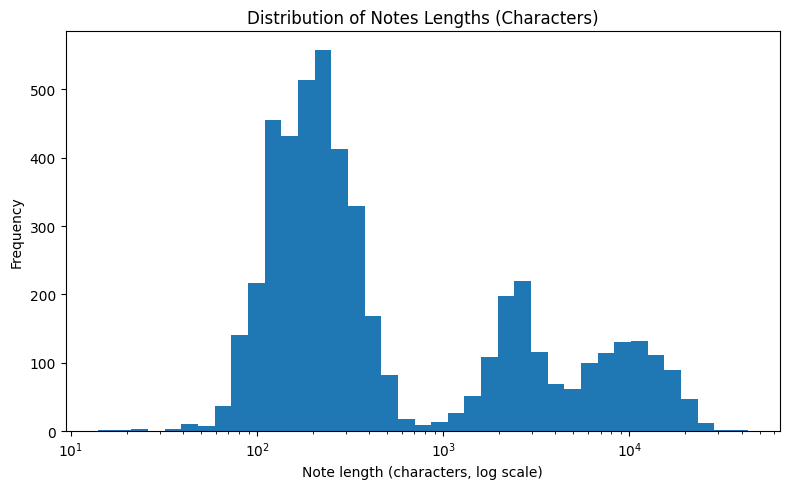

In [ ]:
# === Miscellaneous: Distribution of Notes Lengths (Characters) ===
import numpy as np
import matplotlib.pyplot as plt

# Character counts per note
lengths = notes_df["TEXT"].astype(str).str.len()
lengths = lengths[lengths > 0]

# Log-spaced bins for a log-scale x-axis
bins = np.logspace(np.log10(lengths.min()), np.log10(lengths.max()), 40)

plt.figure(figsize=(8,5))
plt.hist(lengths, bins=bins)
plt.title("Distribution of Notes Lengths (Characters)")
plt.xlabel("Note length (characters, log scale)")
plt.ylabel("Frequency")
plt.xscale("log")
plt.tight_layout()
plt.show()
# Optional: save for your dissertation
# plt.savefig("notes_length_hist.png", dpi=300, bbox_inches="tight")

## **5. Descriptive Statistics of Note Lengths**
Display five-number summary and standard deviation of note lengths.

This cell summarizes descriptive statistics (minimum, quartiles, maximum, and standard deviation) for note lengths in characters and words, helping characterize the textual structure of the dataset.

In [ ]:
import pandas as pd

# Length features
chars = notes_df["TEXT"].astype(str).str.len()
words = notes_df["TEXT"].astype(str).str.split().str.len()

def summarize(s: pd.Series) -> pd.Series:
    return pd.Series({
        "min":    float(s.min()),
        "q1":     float(s.quantile(0.25)),
        "median": float(s.median()),
        "q3":     float(s.quantile(0.75)),
        "max":    float(s.max()),
        "std":    float(s.std(ddof=1)),   # sample SD
    })

summary = pd.concat(
    [summarize(chars), summarize(words)],
    axis=1
)
summary.columns = ["chars", "words"]
summary = summary.loc[["min", "q1", "median", "q3", "max", "std"]].round(2)

# Display (Colab/Jupyter)
from IPython.display import display
display(summary.style.set_caption("Five-number summary (+ SD):"))
# Plain-text alternative:
# print(summary.to_string())


,chars,words
min,14.000000,2.000000
q1,162.000000,22.000000
median,265.000000,36.000000
q3,2315.750000,324.250000
max,43088.000000,6118.000000
std,4430.410000,660.820000


## **6. Regex-Based Weak Labeling for PII Detection and Interpretation**
Define regex patterns (emails, SSNs, phones, addresses) and produce weak labels `y_true`.

This step applies weak supervision through rule-based regular expression (regex) proxies to generate binary proxy labels (PII present vs. absent). These labels provide an approximate ground truth for evaluating clustering and can also be used to bootstrap machine learning models in this case BERT (Bidirectional Encoder Representaions from Transformers) .

The data integration step creates a single analytic table by merging the BigQuery extract of MIMIC-III notes with a binary indicator of potential PII. After loading `notes_df` (with identifiers, demographics, timestamps, and free text), the pipeline compiles regular expressions for common PII surface forms—MIMIC redaction placeholders `[**…**]`, Social Security numbers, telephone numbers, email addresses, address-like strings, and ZIP codes—and applies them to `TEXT`. The result, `proxy_pii ∈ {0,1}`, is appended as a new column (and optionally exported as the vector `y_true`). These **proxy labels** are rule-derived, weak indicators that a note contains content likely to be PII; they are **not** ground truth annotations. In this study they serve only to (a) validate the unsupervised clustering outputs via precision/recall/F1 and (b) calibrate thresholds, thereby linking the clustering stage to privacy-aware evaluation without requiring manual labeling.

“1” means that note matched at least one regex proxy for PII.
In the array, every element is 1, so every sampled note contains at least one proxy match (e.g., an email, phone, ZIP, SSN format, address-like string, or a MIMIC redaction placeholder such as [** ... **]).

Clarifications:

These are proxy matches, not verified ground truth. They can include MIMIC redaction markers (which indicate where PHI originally was) and may yield false positives/negatives.

An all-ones vector often occurs because the placeholder pattern \[ \*\* .*? \*\* \] is frequent in MIMIC notes.

In [ ]:
# Weak labels (proxy PII) – MIMIC placeholders + common PHI regexes
PII_PATTERNS = [
    r"\[\*\*.*?\*\*\]",  # MIMIC redaction placeholders (proxy for PHI locations)
    r"\b\d{3}-\d{2}-\d{4}\b",  # SSN
    r"\b(?:\+?1[\s.-]?)?(?:\(\d{3}\)|\d{3})[\s.-]?\d{3}[\s.-]?\d{4}\b",  # phone
    r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b",  # email
    r"\b\d{1,5}\s+[A-Za-z0-9.\- ]+\s+(?:St|Street|Ave|Avenue|Rd|Road|Blvd|Lane|Ln|Dr|Drive)\b",  # address-ish
    r"\b\d{5}(?:-\d{4})?\b"  # ZIP
]
rx = re.compile("|".join(PII_PATTERNS))
y_true = notes_df["TEXT"].str.contains(rx).astype(int).to_numpy()  # 1 if any proxy PII pattern, else 0

y_true


array([1, 1, 1, ..., 1, 1, 1])

## **7. Feature Engineering and Dimensionality Reduction**
Convert text to TF-IDF vectors, apply Truncated SVD, and normalize for clustering.

Step and Purpose

Step: Feature engineering and unsupervised clustering with model selection.
Purpose: Convert text to vectors, compress to a compact space, normalize, then run DBSCAN over a small grid of eps values and pick the setting that yields the best clustering quality (high silhouette, low Davies–Bouldin).
Note that DBSCAN is chosen insted of KMeans and Hierarchical clustering , beacuse DBSCAN comes with high silhouette, low Davies–Bouldin(DBSCAN: silhouette ≈ 0.445, DBI ≈ 0.994

K-Means: silhouette ≈ 0.189, DBI ≈ 2.641. See below for K-Means result.
Hierarchical: silhouette ≈ 0.204, DBI ≈ 1.472. See below for K-Means and Hierarchical  result

In [ ]:
# Features: TF-IDF -> SVD(100) -> L2 normalize  (compact, robust for DBSCAN)
X_tfidf = TfidfVectorizer(stop_words="english", max_features=3000).fit_transform(notes_df["TEXT"])
X = normalize(TruncatedSVD(n_components=100, random_state=42).fit_transform(X_tfidf))

# DBSCAN (choose eps by small grid on silhouette; noise (-1) excluded for scoring)
def fit_dbscan(eps):
    lab = DBSCAN(eps=eps, min_samples=5, metric="euclidean").fit_predict(X)
    valid = lab != -1
    if valid.sum() > 1 and len(np.unique(lab[valid])) > 1:
        sil = silhouette_score(X[valid], lab[valid])
        dbi = davies_bouldin_score(X[valid], lab[valid])
    else:
        sil, dbi = np.nan, np.nan
    return lab, sil, dbi

candidates = [0.5, 0.7, 0.9]
best = max((fit_dbscan(eps) + (eps,) for eps in candidates),
           key=lambda t: (np.nan_to_num(t[1], nan=-1), -np.nan_to_num(t[2], nan=np.inf)))
labels, sil, dbi, best_eps = best

## **8. Variance Explained by Truncated SVD**
Plot scree and cumulative variance curves to select optimal dimensionality.


Components needed to reach 80% variance: 201
Components needed to reach 90% variance: 201
Components needed to reach 95% variance: 201


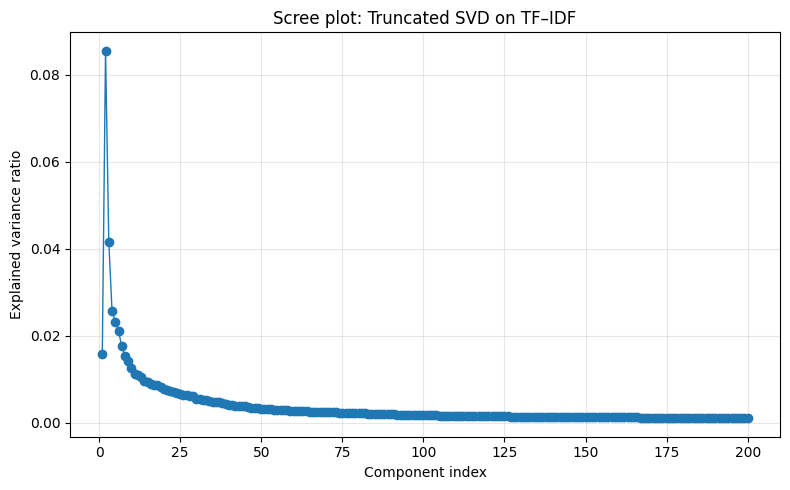

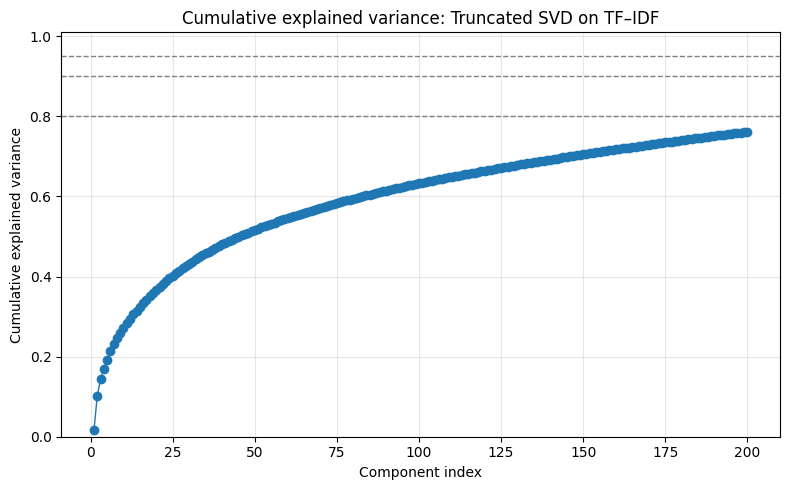

In [ ]:
# --- Scree plot for Truncated SVD on TF–IDF features ---
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

# Assumptions:
# - You already created X_tfidf with TfidfVectorizer on notes_df["TEXT"]
#   e.g., X_tfidf = TfidfVectorizer(stop_words="english", max_features=3000).fit_transform(notes_df["TEXT"])

# 1) Fit SVD with a sufficiently large cap (e.g., 200) to visualize the elbow
n_components_scree = 200
svd_scree = TruncatedSVD(n_components=n_components_scree, random_state=42)
svd_scree.fit(X_tfidf)

explained = svd_scree.explained_variance_ratio_
cum_explained = np.cumsum(explained)

# 2) Report how many components reach common thresholds
for thr in (0.80, 0.90, 0.95):
    k = int(np.searchsorted(cum_explained, thr) + 1)
    print(f"Components needed to reach {int(thr*100)}% variance: {k}")

# 3) Plot: per-component (scree) + cumulative explained variance
plt.figure(figsize=(8,5))
plt.plot(np.arange(1, len(explained)+1), explained, marker='o', linewidth=1)
plt.xlabel("Component index")
plt.ylabel("Explained variance ratio")
plt.title("Scree plot: Truncated SVD on TF–IDF")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("svd_scree_plot.png", dpi=300, bbox_inches="tight")
plt.show()

plt.figure(figsize=(8,5))
plt.plot(np.arange(1, len(cum_explained)+1), cum_explained, marker='o', linewidth=1)
plt.axhline(0.80, color='gray', linestyle='--', linewidth=1)
plt.axhline(0.90, color='gray', linestyle='--', linewidth=1)
plt.axhline(0.95, color='gray', linestyle='--', linewidth=1)
plt.xlabel("Component index")
plt.ylabel("Cumulative explained variance")
plt.title("Cumulative explained variance: Truncated SVD on TF–IDF")
plt.ylim(0, 1.01)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("svd_cumulative_explained.png", dpi=300, bbox_inches="tight")
plt.show()


## **9. Cluster-to-Class Labeling and Evaluation against Weak Labels**
Assign PII/non-PII labels to DBSCAN clusters using weak-label proportion threshold.This section also includes  Visualization of Classification Metrics:Bar chart summarizing precision, recall, and F1 against weak labels.

This section converts unsupervised DBSCAN clusters into binary classifications of “PII present” or “non-PII” by applying a majority threshold (τ = 0.30) based on the proportion of weak labels contained in each cluster.
The resulting cluster-level predictions are then quantitatively evaluated against the regex-based weak labels using standard performance metrics—precision, recall, and F₁-score—to assess how closely the clustering output aligns with the proxy labeling baseline.
This evaluation provides insight into the consistency between the unsupervised clustering patterns and the rule-based PII proxies, thereby serving as an intermediary validation stage before integrating transformer-based models.

DBSCAN eps=0.5 | silhouette=0.419 | DBI=1.021 | noise=59.8%
Weak-label positives: 3736 of 5000 (74.7%)
Precision=0.951 | Recall=0.489 | F1=0.646


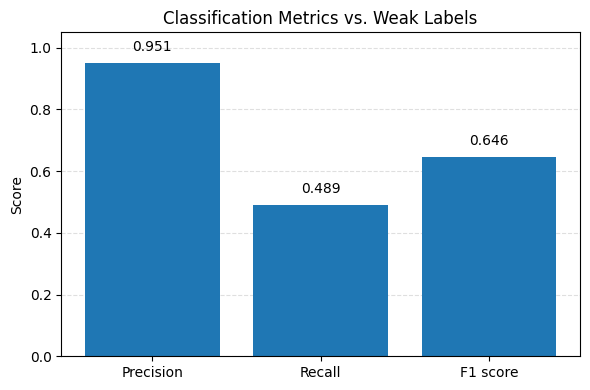

In [ ]:
# Cluster->PII mapping by majority of weak labels (threshold τ)
tau = 0.30
cluster_ids = np.unique(labels[labels != -1])
cluster_to_pii = {c: int(y_true[labels == c].mean() >= tau) for c in cluster_ids}
y_pred = np.array([cluster_to_pii.get(l, 0) for l in labels])  # noise -> 0 (non-PII) by default

# Metrics (vs weak labels) + quick summary for slides
prec = precision_score(y_true, y_pred, zero_division=0)
rec  = recall_score(y_true, y_pred, zero_division=0)
f1   = f1_score(y_true, y_pred, zero_division=0)

print(f"DBSCAN eps={best_eps} | silhouette={sil:.3f} | DBI={dbi:.3f} | noise={(labels==-1).mean():.1%}")
print(f"Weak-label positives: {y_true.sum()} of {len(y_true)} ({y_true.mean():.1%})")
print(f"Precision={prec:.3f} | Recall={rec:.3f} | F1={f1:.3f}")


metrics = ["Precision", "Recall", "F1 score"]
scores  = [prec, rec, f1]  # or [0.955, 0.476, 0.635]

fig, ax = plt.subplots(figsize=(6,4))
ax.bar(metrics, scores, zorder=2)

ax.set_title("Classification Metrics vs. Weak Labels")
ax.set_ylabel("Score")
ax.set_ylim(0, 1.05)            # headroom above 1.0
ax.set_axisbelow(True)           # draw grid behind bars/text
ax.yaxis.grid(True, linestyle="--", alpha=0.4, zorder=0)

# value labels (avoid overlap with grid/top)
for i, v in enumerate(scores):
    y = min(v + 0.03, ax.get_ylim()[1] - 0.02)
    ax.text(i, y, f"{v:.3f}", ha="center", va="bottom", zorder=3)

plt.tight_layout()
plt.show()


## **10. Classification Report – Model Performance**
Generate full report (precision, recall, F1, support) for hybrid predictions.

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=["Non-PII", "PII"]))

              precision    recall  f1-score   support

     Non-PII       0.38      0.92      0.54      1264
         PII       0.95      0.49      0.65      3736

    accuracy                           0.60      5000
   macro avg       0.67      0.71      0.59      5000
weighted avg       0.81      0.60      0.62      5000



## **11. Threshold Optimization (τ Sweep)**
Systematically test multiple τ values to refine cluster-to-label mapping.

This step tests multiple cluster-level probability thresholds (τ) to map clusters to PII/non-PII predictions. Precision, recall, and F1 are computed for each τ to identify the optimal balance between sensitivity and specificity.

In [ ]:
import numpy as np, pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

assert "labels" in globals() and "y_true" in globals(), "Run clustering and weak-label creation first."

taus = [0.90, 0.70, 0.50, 0.30]
cluster_ids = np.unique(labels[labels != -1])

def preds_at_tau(tau):
    # cluster-level P(PII) using weak labels
    c2pii = {c: int(y_true[labels == c].mean() >= tau) for c in cluster_ids}
    # default: DBSCAN noise (-1) → non-PII
    return np.array([c2pii.get(l, 0) for l in labels])

rows = []
for t in taus:
    y_hat = preds_at_tau(t)
    rows.append({
        "tau": t,
        "precision": precision_score(y_true, y_hat, zero_division=0),
        "recall":    recall_score(y_true, y_hat, zero_division=0),
        "f1":        f1_score(y_true, y_hat, zero_division=0)
    })

tau_report = pd.DataFrame(rows).sort_values("tau", ascending=False)
print(tau_report.to_string(index=False, float_format=lambda v: f"{v:.3f}"))


  tau  precision  recall    f1
0.900      1.000   0.453 0.623
0.700      0.997   0.458 0.628
0.500      0.964   0.483 0.644
0.300      0.951   0.489 0.646


## **12. BERT-Based Named Entity Recognition (NER)**
Run transformer model (`dslim/bert-base-NER`) to extract PII entities (PER, ORG, LOC)

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline

tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")
ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple")

def detect_bert_pii(text):
    entities = ner_pipeline(text)
    pii_tags = {"PER", "ORG", "LOC"}
    return int(any(ent["entity_group"] in pii_tags for ent in entities))

notes_df["bert_pii"] = notes_df["TEXT"].apply(lambda t: detect_bert_pii(t[:512]))  # limit length for efficiency

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


## **13. Regex + BERT Hybrid Weak Label Integration**
Combine outputs into unified hybrid labels for improved PII detection.

In [ ]:
# 3) Weak labels (proxy PII) – MIMIC placeholders + common PHI regexes + BERT Labels
PII_PATTERNS = [
    r"\[\*\*.*?\*\*\]",  # MIMIC redaction placeholders (proxy for PHI locations)
    r"\b\d{3}-\d{2}-\d{4}\b",  # SSN
    r"\b(?:\+?1[\s.-]?)?(?:\(\d{3}\)|\d{3})[\s.-]?\d{3}[\s.-]?\d{4}\b",  # phone
    r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b",  # email
    r"\b\d{1,5}\s+[A-Za-z0-9.\- ]+\s+(?:St|Street|Ave|Avenue|Rd|Road|Blvd|Lane|Ln|Dr|Drive)\b",  # address-ish
    r"\b\d{5}(?:-\d{4})?\b"  # ZIP
]
rx = re.compile("|".join(PII_PATTERNS))
notes_df["proxy_pii"] = notes_df["TEXT"].str.contains(rx).astype(int)  # 1 if any proxy PII pattern, else 0

notes_df["combined_pii"] = ((notes_df["proxy_pii"] + notes_df["bert_pii"]) > 0).astype(int)
y_true = notes_df["combined_pii"].to_numpy()

## **14. Visualization – Hybrid Label Metrics Comparison**
Plot performance (precision, recall, F1) for hybrid vs. individual labeling methods.

In [ ]:
# --- 6) Cluster -> PII mapping by majority of HYBRID weak labels (regex ∪ BERT) ---
# Assumes you already created:
# notes_df["proxy_pii"], notes_df["bert_pii"], notes_df["combined_pii"]
# and set: y_true = notes_df["combined_pii"].to_numpy()

tau = 0.30
cluster_ids = np.unique(labels[labels != -1])
cluster_to_pii = {c: int(y_true[labels == c].mean() >= tau) for c in cluster_ids}
y_pred = np.array([cluster_to_pii.get(l, 0) for l in labels])  # noise -> 0 (non-PII)

# --- 7) Metrics (vs HYBRID weak labels) + concise summary for slides ---
from sklearn.metrics import precision_score, recall_score, f1_score

prec = precision_score(y_true, y_pred, zero_division=0)
rec  = recall_score(y_true, y_pred, zero_division=0)
f1   = f1_score(y_true, y_pred, zero_division=0)

n = len(y_true)
regex_pos = int(notes_df["proxy_pii"].sum())
bert_pos  = int(notes_df["bert_pii"].sum())
union_pos = int(notes_df["combined_pii"].sum())
intersect_pos = int(((notes_df["proxy_pii"] == 1) & (notes_df["bert_pii"] == 1)).sum())

print(f"DBSCAN eps={best_eps} | silhouette={sil:.3f} | DBI={dbi:.3f} | noise={(labels==-1).mean():.1%}")
print(f"Hybrid weak-label (regex ∪ BERT) positives: {union_pos} of {n} ({union_pos/n:.1%})")
print(f"  - Regex-only positives: {regex_pos} ({regex_pos/n:.1%})")
print(f"  - BERT-only positives:  {bert_pos} ({bert_pos/n:.1%})")
print(f"  - Intersection (regex ∩ BERT): {intersect_pos} ({intersect_pos/n:.1%})")
print(f"Precision={prec:.3f} | Recall={rec:.3f} | F1={f1:.3f}")


DBSCAN eps=0.5 | silhouette=0.419 | DBI=1.021 | noise=59.8%
Hybrid weak-label (regex ∪ BERT) positives: 3822 of 5000 (76.4%)
  - Regex-only positives: 3736 (74.7%)
  - BERT-only positives:  971 (19.4%)
  - Intersection (regex ∩ BERT): 885 (17.7%)
Precision=0.954 | Recall=0.479 | F1=0.638


## **15. Extraction and Analysis of Prefix Tokens Before PII Entities**
Identify frequent tokens preceding PII entities to examine contextual patterns.This cell identifies and summarizes short prefix phrases that occur immediately before PII (e.g., “my name is,” “social security number,” “phone number”). Using regular expressions for common PII types, it extracts up to 60 characters before each match, aggregates prefix frequencies by PII type, and prints redacted concordance lines for audit. This approach aligns interpretability with PII morphology and, allowing the verify that detections arise from realistic cue phrases and to spot error modes (e.g., placeholder saturation or missing cues). The resulting prefix counts can inform feature augmentation (cue-phrase indicators, character n-grams) and operating-point selection in the refinement steps.

In [ ]:
# Prefixes before PII (very short version)
import re, pandas as pd

assert "notes_df" in globals() and "TEXT" in notes_df

PII = re.compile(r"(.{0,60}?)(\b\d{3}-\d{2}-\d{4}\b|"                 # SSN
                 r"\b(?:\+?1[\s.\-]?)?(?:\(\d{3}\)|\d{3})[\s.\-]?\d{3}[\s.\-]?\d{4}\b|"  # phone
                 r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b|"                  # email
                 r"\b\d{5}(?:-\d{4})?\b|"                                                # ZIP
                 r"\b\d{1,2}[/-]\d{1,2}[/-]\d{2,4}\b)", re.I)                            # date mm/dd/yyyy

pref, samp = [], []
for txt in notes_df["TEXT"].astype(str):
    for m in PII.finditer(txt):
        left = " ".join(re.findall(r"\b\w+\b", m.group(1))[-4:]).lower()   # last 4 tokens before PII
        pref.append(left)
        s, e = m.span(2)
        ctx = txt[max(0, s-35): min(len(txt), e+35)]
        samp.append((left, re.sub(re.escape(m.group(2)), "[PII]", ctx)))

# Top prefixes
print(pd.Series(pref).value_counts().head(15).to_string())

# Sample redacted concordance lines
print("\nSamples:")
print(pd.DataFrame(samp, columns=["prefix","concordance"]).groupby("prefix").head(2).to_string(index=False))


job job number                         200
dr last name stitle                    187
telephone fax 1                         75
mr known lastname                       67
by last name namepattern1               63
phone telephone fax 1                   55
ms known lastname                       51
d md number 1                           47
at telephone fax 1                      38
number telephone fax 1                  34
attending first name3 lf                34
call telephone fax 1                    33
numeric identifier                      33
namepattern1 last name namepattern1     31
namepattern2 last name namepattern1     31

Samples:
                                  prefix                                                                           concordance
                                   abg 7       al cannula\n   SPO2: 100%\n   ABG: 7.[PII]//0\n   Physical Examination\n   Gene
                                   abg 7         .6 cmH2O/mL\n   SPO2: 99%\n   ABG: 7.[PII]

## **16a. Comparative Evaluation: DBSCAN vs. K-Means**
Assess internal validity (Silhouette, DBI) for both algorithms.

In [ ]:
# === side-by-side scores & heatmaps (DBSCAN vs KMeans) ===
def _metrics(X, labels, drop_noise=True):
    """Return (silhouette, dbi). If drop_noise and DBSCAN noise (-1) exists, exclude it."""
    if drop_noise and (-1 in labels):
        m = labels != -1
        if m.sum() < 2 or len(np.unique(labels[m])) < 2:
            return np.nan, np.nan
        return silhouette_score(X[m], labels[m]), davies_bouldin_score(X[m], labels[m])
    if len(np.unique(labels)) < 2:
        return np.nan, np.nan
    return silhouette_score(X, labels), davies_bouldin_score(X, labels)

    # ---- DBSCAN: Grid style
try:
    sil_dbscan, dbi_dbscan, labels_db = sil, dbi, labels
except NameError:
    eps_grid_seed = [0.5, 0.7, 0.9]
    best = (np.nan, np.inf, None, None)
    for eps in eps_grid_seed:
        lab = DBSCAN(eps=eps, min_samples=5, metric="euclidean").fit_predict(X)
        s, d = _metrics(X, lab, drop_noise=True)
        if (np.nan_to_num(s, nan=-1) > np.nan_to_num(best[0], nan=-1)) or \
           (np.isfinite(s) and np.isclose(s, best[0]) and np.nan_to_num(d, nan=np.inf) < np.nan_to_num(best[1], nan=np.inf)):
            best = (s, d, lab, eps)
    sil_dbscan, dbi_dbscan, labels_db, best_eps = best

    # ---- KMEANS: evaluate across k and take the silhouette-best k
ks = range(2, 11)
sil_k_list, dbi_k_list = [], []
for k in ks:
    lab = KMeans(n_clusters=k, n_init=10, random_state=42).fit_predict(X)
    s, d = _metrics(X, lab, drop_noise=False)
    sil_k_list.append(s); dbi_k_list.append(d)
k_best = ks[int(np.nanargmax(sil_k_list))]
labels_km = KMeans(n_clusters=k_best, n_init=10, random_state=42).fit_predict(X)
sil_km, dbi_km = _metrics(X, labels_km, drop_noise=False)

## **16b. Visualization of Clustering Scores**
Plot bar charts comparing DBSCAN and K-Means performance metrics.

Algorithm  Silhouette  Davies–Bouldin
   KMeans       0.190           2.657
   DBSCAN       0.419           1.021


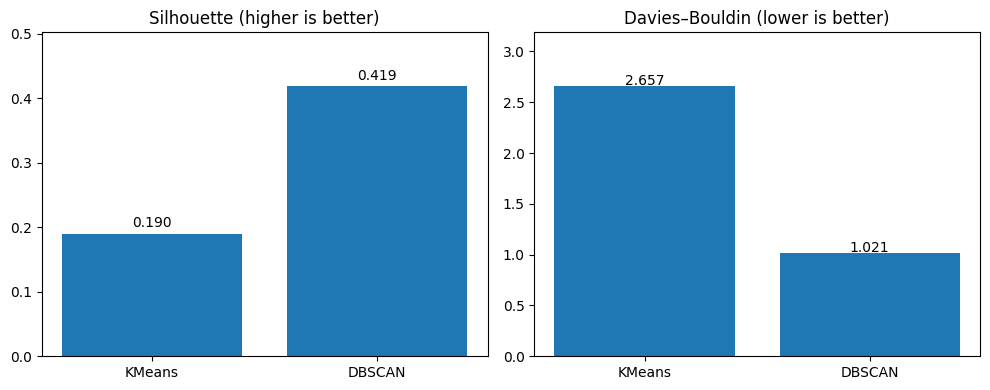

In [ ]:
# ---- Print scores side by side
scores = pd.DataFrame(
    {"Algorithm": ["KMeans", "DBSCAN"],
     "Silhouette": [sil_km, sil_dbscan],
     "Davies–Bouldin": [dbi_km, dbi_dbscan]}
)
print(scores.to_string(index=False, float_format=lambda v: f"{v:.3f}"))

# ---- Bar charts: Silhouette and DBI side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].bar(["KMeans", "DBSCAN"], [sil_km, sil_dbscan])
ax[0].set_title("Silhouette (higher is better)"); ax[0].set_ylim(0, max(0.0, np.nanmax([sil_km, sil_dbscan]))*1.2)
for i, v in enumerate([sil_km, sil_dbscan]):
    if not np.isnan(v): ax[0].text(i, v + 0.01, f"{v:.3f}", ha="center")

ax[1].bar(["KMeans", "DBSCAN"], [dbi_km, dbi_dbscan])
ax[1].set_title("Davies–Bouldin (lower is better)"); ax[1].set_ylim(0, max(0.0, np.nanmax([dbi_km, dbi_dbscan]))*1.2)
for i, v in enumerate([dbi_km, dbi_dbscan]):
    if not np.isnan(v): ax[1].text(i, v + 0.01, f"{v:.3f}", ha="center")
fig.tight_layout(); plt.show()

## **17a. Heatmaps of Silhouette Scores**
Display parameter-grid heatmaps (ε/ min_samples for DBSCAN; k for K-Means).

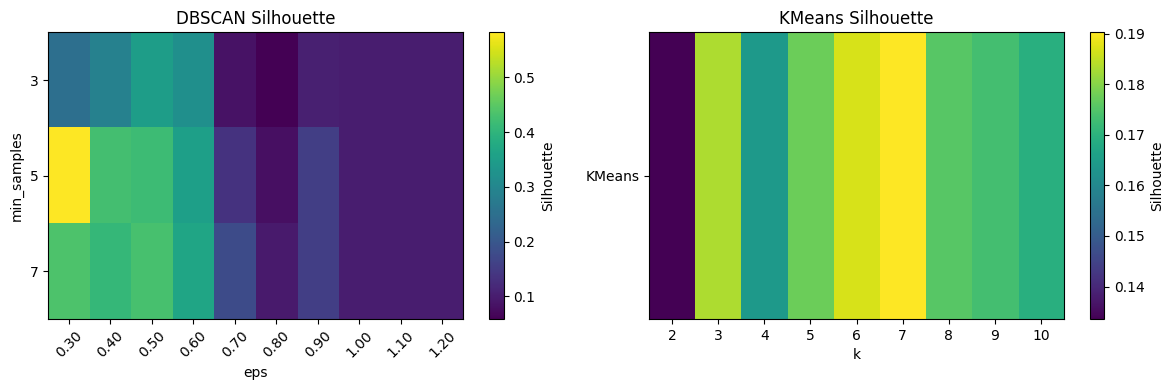

In [ ]:
# ---- Heatmaps: DBSCAN vs KMeans (Silhouette)
eps_grid = np.linspace(0.3, 1.2, 10)
min_samples_grid = [3, 5, 7]
sil_db = np.full((len(min_samples_grid), len(eps_grid)), np.nan)
dbi_db = np.full_like(sil_db, np.nan)
for i, ms in enumerate(min_samples_grid):
    for j, eps in enumerate(eps_grid):
        lab = DBSCAN(eps=eps, min_samples=ms, metric="euclidean").fit_predict(X)
        s, d = _metrics(X, lab, drop_noise=True)
        sil_db[i, j] = s; dbi_db[i, j] = d

ks_grid = np.arange(2, 11)
sil_k_hm, dbi_k_hm = [], []
for k in ks_grid:
    lab = KMeans(n_clusters=k, n_init=10, random_state=42).fit_predict(X)
    s, d = _metrics(X, lab, drop_noise=False)
    sil_k_hm.append(s); dbi_k_hm.append(d)
sil_k_hm = np.array(sil_k_hm)[None, :]
dbi_k_hm = np.array(dbi_k_hm)[None, :]

# Silhouette heatmaps: DBSCAN vs KMeans (side by side)
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
im0 = ax[0].imshow(sil_db, aspect="auto"); fig.colorbar(im0, ax=ax[0], label="Silhouette")
ax[0].set_title("DBSCAN Silhouette"); ax[0].set_xlabel("eps"); ax[0].set_ylabel("min_samples")
ax[0].set_xticks(range(len(eps_grid))); ax[0].set_xticklabels([f"{e:.2f}" for e in eps_grid], rotation=45)
ax[0].set_yticks(range(len(min_samples_grid))); ax[0].set_yticklabels(min_samples_grid)

im1 = ax[1].imshow(sil_k_hm, aspect="auto"); fig.colorbar(im1, ax=ax[1], label="Silhouette")
ax[1].set_title("KMeans Silhouette"); ax[1].set_xlabel("k"); ax[1].set_yticks([0]); ax[1].set_yticklabels(["KMeans"])
ax[1].set_xticks(range(len(ks_grid))); ax[1].set_xticklabels([str(k) for k in ks_grid])
fig.tight_layout(); plt.show()

## **17b. Heatmaps of DBI Scores**
Display parameter-grid heatmaps (ε/ min_samples for DBSCAN; k for K-Means).

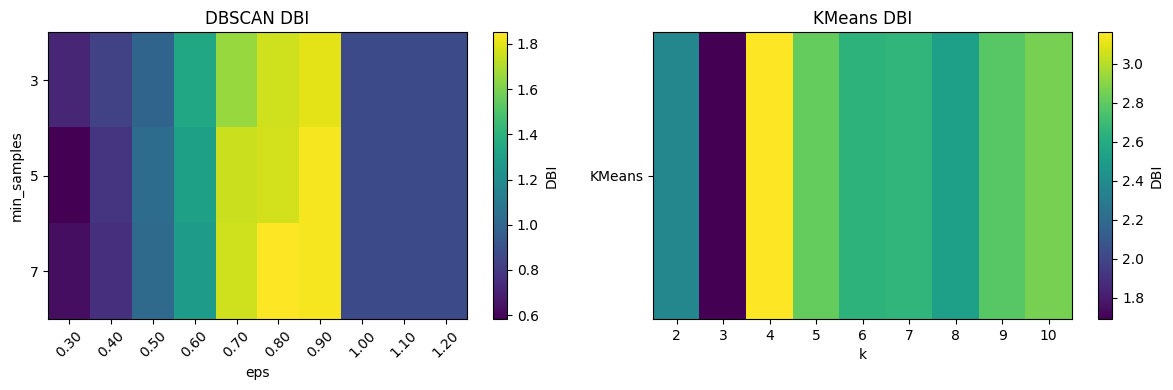

In [ ]:
# DBI heatmaps: DBSCAN vs KMeans (side by side)
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
im0 = ax[0].imshow(dbi_db, aspect="auto"); fig.colorbar(im0, ax=ax[0], label="DBI")
ax[0].set_title("DBSCAN DBI"); ax[0].set_xlabel("eps"); ax[0].set_ylabel("min_samples")
ax[0].set_xticks(range(len(eps_grid))); ax[0].set_xticklabels([f"{e:.2f}" for e in eps_grid], rotation=45)
ax[0].set_yticks(range(len(min_samples_grid))); ax[0].set_yticklabels(min_samples_grid)

im1 = ax[1].imshow(dbi_k_hm, aspect="auto"); fig.colorbar(im1, ax=ax[1], label="DBI")
ax[1].set_title("KMeans DBI"); ax[1].set_xlabel("k"); ax[1].set_yticks([0]); ax[1].set_yticklabels(["KMeans"])
ax[1].set_xticks(range(len(ks_grid))); ax[1].set_xticklabels([str(k) for k in ks_grid])
fig.tight_layout(); plt.show()

## **18. Hierarchical Clustering (Ward Linkage) Benchmark**
Add agglomerative baseline and compare quality indices.

This section applies hierarchical clustering with Ward linkage to the reduced embeddings, computes Silhouette and Davies–Bouldin scores for different cluster counts (k=2–10), and compares results against DBSCAN and KMeans.

          Algorithm k/eps  Silhouette  Davies–Bouldin
Hierarchical (Ward)     4       0.204           1.472
             KMeans    k*       0.190           2.656
             DBSCAN 0.500       0.418           1.033


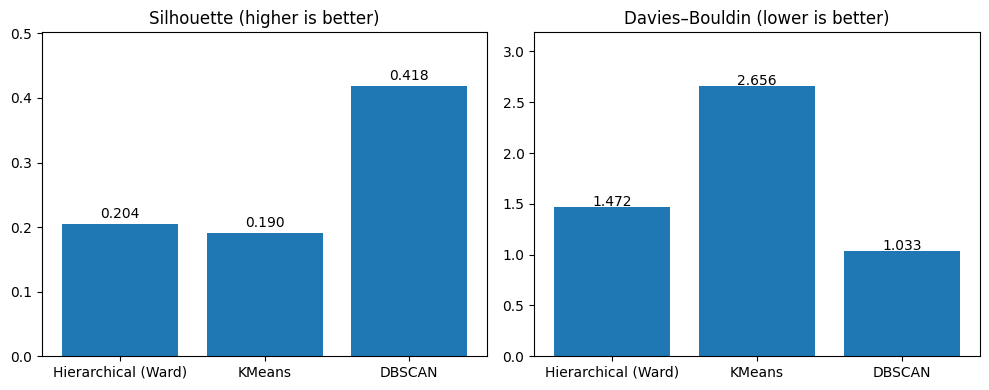

In [ ]:
# === Hierarchical (Agglomerative) Clustering: Silhouette & Davies–Bouldin ===
import numpy as np, pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize

# Reuse your embedding X if available; otherwise build a compact fallback from notes_df["TEXT"]
def _ensure_X():
    if "X" in globals():
        return X
    assert "notes_df" in globals() and "TEXT" in notes_df, "Provide notes_df['TEXT'] or define X."
    _X_tfidf = TfidfVectorizer(stop_words="english", max_features=3000).fit_transform(notes_df["TEXT"])
    return normalize(TruncatedSVD(n_components=100, random_state=42).fit_transform(_X_tfidf))

X_h = _ensure_X()

# Reuse your helper if defined; else define a compatible one (no noise in hierarchical clustering)
def _metrics_if_missing(X, labels):
    if len(np.unique(labels)) < 2:
        return np.nan, np.nan
    return silhouette_score(X, labels), davies_bouldin_score(X, labels)

if "_metrics" in globals():
    _mx = _metrics
else:
    _mx = lambda X, lab, drop_noise=False: _metrics_if_missing(X, lab)

# Evaluate AgglomerativeClustering over k=2..10 and select the silhouette-best k
ks_h = range(2, 11)
sil_h_list, dbi_h_list = [], []
for k in ks_h:
    # Ward linkage requires Euclidean metric and is standard for numeric embeddings
    lab_h = AgglomerativeClustering(n_clusters=k, linkage="ward").fit_predict(X_h)
    s_h, d_h = _mx(X_h, lab_h, drop_noise=False)
    sil_h_list.append(s_h); dbi_h_list.append(d_h)

k_best_h = ks_h[int(np.nanargmax(sil_h_list))]
labels_h = AgglomerativeClustering(n_clusters=k_best_h, linkage="ward").fit_predict(X_h)
sil_h, dbi_h = _mx(X_h, labels_h, drop_noise=False)

# Assemble comparison table (include KMeans/DBSCAN if available)
rows = [{"Algorithm": "Hierarchical (Ward)", "k/eps": k_best_h, "Silhouette": sil_h, "Davies–Bouldin": dbi_h}]
if "sil_km" in globals() and "dbi_km" in globals():
    rows.append({"Algorithm": "KMeans", "k/eps": "k*",
                 "Silhouette": sil_km, "Davies–Bouldin": dbi_km})
if "sil_dbscan" in globals() and "dbi_dbscan" in globals():
    rows.append({"Algorithm": "DBSCAN", "k/eps": globals().get("best_eps", "eps*"),
                 "Silhouette": sil_dbscan, "Davies–Bouldin": dbi_dbscan})

comp_h = pd.DataFrame(rows)[["Algorithm", "k/eps", "Silhouette", "Davies–Bouldin"]]
print(comp_h.to_string(index=False, float_format=lambda v: f"{v:.3f}"))

# Optional: bar charts including Hierarchical
try:
    import matplotlib.pyplot as plt
    algs = comp_h["Algorithm"].tolist()
    sils = comp_h["Silhouette"].tolist()
    dbis = comp_h["Davies–Bouldin"].tolist()

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].bar(algs, sils)
    ax[0].set_title("Silhouette (higher is better)")
    ax[0].set_ylim(0, max([v for v in sils if np.isfinite(v)] + [0]) * 1.2)
    for i, v in enumerate(sils):
        if np.isfinite(v): ax[0].text(i, v + 0.01, f"{v:.3f}", ha="center")

    ax[1].bar(algs, dbis)
    ax[1].set_title("Davies–Bouldin (lower is better)")
    ax[1].set_ylim(0, max([v for v in dbis if np.isfinite(v)] + [0]) * 1.2)
    for i, v in enumerate(dbis):
        if np.isfinite(v): ax[1].text(i, v + 0.01, f"{v:.3f}", ha="center")

    fig.tight_layout(); plt.show()
except Exception as e:
    print("Plotting skipped:", e)

# Notes:
# - Ward linkage uses Euclidean distances and is appropriate for your SVD+L2-normalized embeddings.
# - If you wish to try cosine distances, use linkage='average' and metric='cosine' in newer scikit-learn versions,
#   e.g., AgglomerativeClustering(n_clusters=k, linkage='average', metric='cosine').
